In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.util import pairplot

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

figdir = "./"

In [2]:
g_el = Parameter("g_el", 1, lb=0.1, ub=7.)
g_synA = Parameter("g_synA", 1, lb=0.1, ub=10.)

# Define model
name = "STG"
parameters = [g_el, g_synA]
model = Model(name, parameters)

In [3]:
# Define model
name = "STG"
model = Model(name, parameters)

In [4]:
import tensorflow as tf
DTYPE = tf.float32
# Emergent property values.
mu = np.array([0.53, 0.025**2])

def network_freq(g_el, g_synA):
    """Simulate the STG circuit given parameters z.

    # Arguments
        z (tf.tensor): Density network system parameter samples.

    # Returns
        g(z) (tf.tensor): Simulated system activity.

    """

    g_el = 1e-9*g_el[:,0]
    g_synA = 1e-9*g_synA[:,0]

    # get number of batch samples
    M = g_el.shape[0]

    # Set constant parameters.
    # conductances
    C_m = 1.0e-9
    
    g_synB = 5e-9
    # volatages
    V_leak = -40.0e-3  # 40 mV
    V_Ca = 100.0e-3  # 100mV
    V_k = -80.0e-3  # -80mV
    V_h = -20.0e-3  # -20mV
    V_syn = -75.0e-3  # -75mV

    v_1 = 0.0  # 0mV
    v_2 = 20.0e-3  # 20mV
    v_3 = 0.0  # 0mV
    v_4 = 15.0e-3  # 15mV
    v_5 = 78.3e-3  # 78.3mV
    v_6 = 10.5e-3  # 10.5mV
    v_7 = -42.2e-3  # -42.2mV
    v_8 = 87.3e-3  # 87.3mV
    v_9 = 5.0e-3  # 5.0mV

    v_th = -25.0e-3  # -25mV

    # neuron specific conductances
    g_Ca_f = 1.9e-2 * (1e-6)  # 1.9e-2 \mu S
    g_Ca_h = 1.7e-2 * (1e-6)  # 1.7e-2 \mu S
    g_Ca_s = 8.5e-3 * (1e-6)  # 8.5e-3 \mu S

    g_k_f = 3.9e-2 * (1e-6)  # 3.9e-2 \mu S
    g_k_h = 1.9e-2 * (1e-6)  # 1.9e-2 \mu S
    g_k_s = 1.5e-2 * (1e-6)  # 1.5e-2 \mu S

    g_h_f = 2.5e-2 * (1e-6)  # 2.5e-2 \mu S
    g_h_h = 8.0e-3 * (1e-6)  # 8.0e-3 \mu S
    g_h_s = 1.0e-2 * (1e-6)  # 1.0e-2 \mu S

    g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s], dtype=np.float32)
    g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s], dtype=np.float32)
    g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s], dtype=np.float32)

    g_leak = 1.0e-4 * (1e-6)  # 1e-4 \mu S

    phi_N = 2  # 0.002 ms^-1

    _zeros = tf.zeros((M,), dtype=DTYPE)
    
    def f(x, g_el, g_synA):
        # x contains
        V_m = x[:, :5]
        N = x[:, 5:10]
        H = x[:, 10:]

        M_inf = 0.5 * (1.0 + tf.tanh((V_m - v_1) / v_2))
        N_inf = 0.5 * (1.0 + tf.tanh((V_m - v_3) / v_4))
        H_inf = 1.0 / (1.0 + tf.exp((V_m + v_5) / v_6))

        S_inf = 1.0 / (1.0 + tf.exp((v_th - V_m) / v_9))

        I_leak = g_leak * (V_m - V_leak)
        I_Ca = g_Ca * M_inf * (V_m - V_Ca)
        I_k = g_k * N * (V_m - V_k)
        I_h = g_h * H * (V_m - V_h)

        I_elec = tf.stack(
            [
                _zeros,
                g_el * (V_m[:, 1] - V_m[:, 2]),
                g_el * (V_m[:, 2] - V_m[:, 1] + V_m[:, 2] - V_m[:, 4]),
                _zeros,
                g_el * (V_m[:, 4] - V_m[:, 2]),
            ],
            axis=1,
        )

        I_syn = tf.stack(
            [
                g_synB * S_inf[:, 1] * (V_m[:, 0] - V_syn),
                g_synB * S_inf[:, 0] * (V_m[:, 1] - V_syn),
                g_synA * S_inf[:, 0] * (V_m[:, 2] - V_syn)
                + g_synA * S_inf[:, 3] * (V_m[:, 2] - V_syn),
                g_synB * S_inf[:, 4] * (V_m[:, 3] - V_syn),
                g_synB * S_inf[:, 3] * (V_m[:, 4] - V_syn),
            ],
            axis=1,
        )

        I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn

        lambda_N = (phi_N) * tf.math.cosh((V_m - v_3) / (2 * v_4))
        tau_h = (272.0 - (-1499.0 / (1.0 + tf.exp((-V_m + v_7) / v_8)))) / 1000.0

        dVmdt = (1.0 / C_m) * (-I_total + 1e-11*tf.random.normal(I_total.shape, 0., 1.))
        dNdt = lambda_N * (N_inf - N)
        dHdt = (H_inf - H) / tau_h

        dxdt = tf.concat((dVmdt, dNdt, dHdt), axis=1)
        return dxdt
    
    x0 = tf.constant(
            [
                -0.04169771,
                -0.04319491,
                0.00883992,
                -0.06879824,
                0.03048103,
                0.00151316,
                0.19784773,
                0.56514935,
                0.12214069,
                0.35290397,
                0.08614699,
                0.04938177,
                0.05568701,
                0.07007949,
                0.05790969,
            ],
            dtype=DTYPE
        )

    x0 = tf.tile(tf.expand_dims(x0, 0), [M, 1])

    x = x0
    vs = [x[:, 2]]
    T = 200
    dt = 0.025
    for i in range(T):
        dxdt = f(x, g_el, g_synA)
        x = x + dxdt * dt
        vs.append(x[:, 2])

    x_t = tf.stack(vs, axis=0)

    # sampling frequency
    fft_start = 20
    w = 20
    Fs = 1.0 / dt
    # num samples for freq measurement
    N = T - fft_start + 1 - (w - 1)

    min_freq = 0.0
    max_freq = 1.0
    num_freqs = 101
    freqs = np.linspace(min_freq, max_freq, num_freqs, dtype=np.float32)[:,None]
    
    ns = np.arange(0, N)
    phis = []
    for i in range(num_freqs):
        k = N * freqs[i] / Fs
        phi = np.cos(2 * np.pi * k * ns / N) - 1j * np.sin(2 * np.pi * k * ns / N)
        phis.append(phi)

    # [T, K]
    Phi = tf.constant(np.array(phis).T, dtype=tf.complex64)

    avg_filter = (1.0 / w) * tf.ones((w, 1, 1), dtype=DTYPE)

    v = tf.transpose(x_t[:,:,None], [1,0,2])[:,fft_start:, :]
    v_rect = tf.nn.relu(v)  # [M5,T-fft,1]
    v_rect_LPF = tf.nn.conv1d(v_rect, avg_filter, stride=1, padding="VALID")[
        :, :, 0
    ]

    v_rect_LPF = v_rect_LPF - tf.expand_dims(tf.reduce_mean(v_rect_LPF, 1), 1)

    V = tf.matmul(tf.cast(v_rect_LPF, tf.complex64), Phi)

    V_pow = tf.exp(50.*tf.abs(V))
    freq_id = V_pow / tf.expand_dims(tf.reduce_sum(V_pow, 1), 1)

    f_h = tf.matmul(freq_id, freqs)  # (1 x M5)
    T_x = tf.concat((f_h, tf.square(f_h - mu[0])), 1)

    return T_x

model.set_eps(network_freq)

In [25]:
epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['mu'] = [ep['mu'] for ep in epi_df['EP']]
epi_df['random_seed'] = [arch['random_seed'] for arch in epi_df['arch']]

# select by c0
epi_df = epi_df[epi_df['c0']==100.]

epi_df = epi_df[[np.isclose(_mu, mu).all() for _mu in epi_df['mu']]]

paths = sorted(epi_df['path'].unique())
for i, path in enumerate(paths):
    print(i, path)


0 data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00
1 data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
2 data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs2/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00
3 data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs2/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
4 data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.99E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00
5 data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.99E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_g

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00


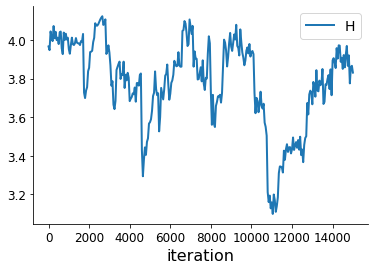

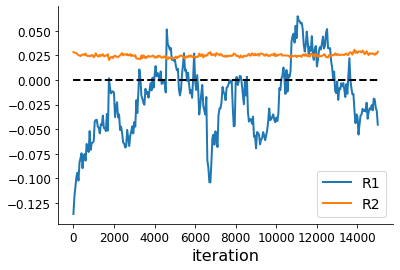

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00


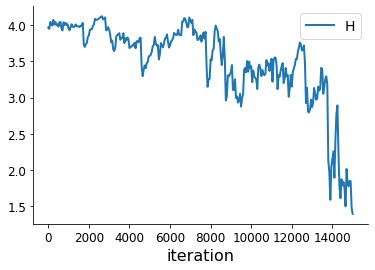

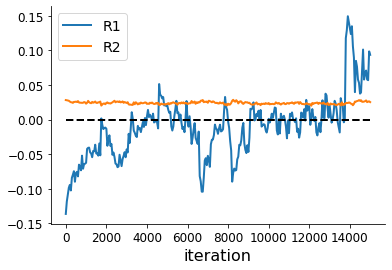

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs2/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00


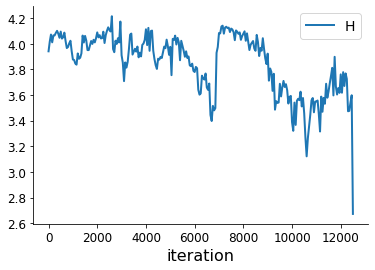

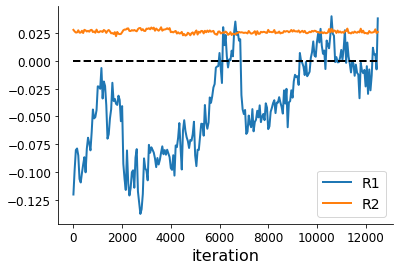

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs2/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00


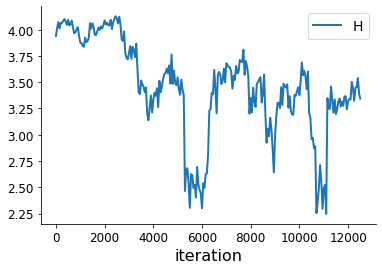

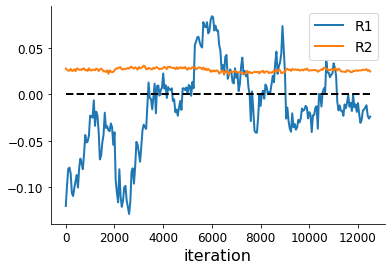

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.99E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00


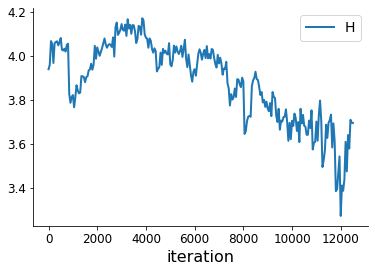

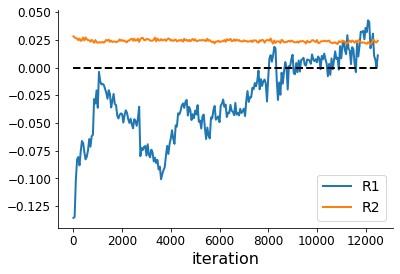

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.99E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00


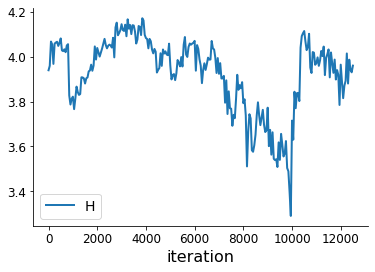

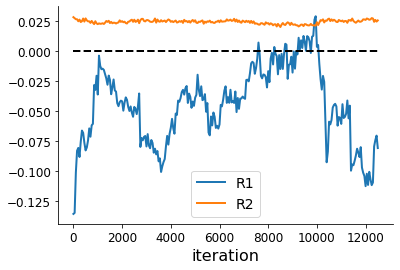

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.99E-01_PA_rs2/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00


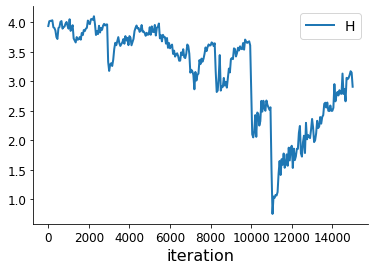

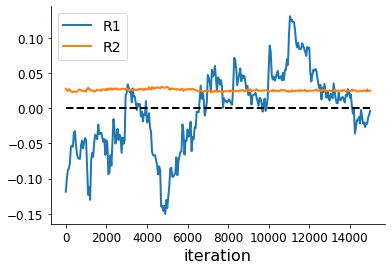

data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.99E-01_PA_rs2/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00


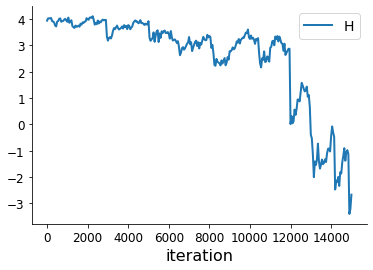

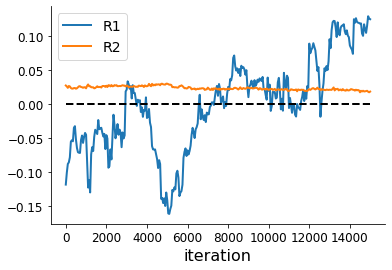

In [27]:
for path in paths:
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    epi_df2.plot('iteration', 'H')
    plt.show()
    Rs = ['R%d' % r for r in range(1,3)]
    epi_df2.plot('iteration', Rs)
    plt.plot([0, epi_df2['iteration'].max()], [0, 0], 'k--')
    #plt.ylim([-1,1])
    plt.show()

ckpt_dir data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+01_gamma2.50E-01_beta2.00E+00
os list ['ckpt-4.data-00000-of-00001', 'ckpt-5.data-00000-of-00001', 'checkpoint', 'ckpt-1.data-00000-of-00001', 'ckpt-0.data-00000-of-00001', 'ckpt-3.data-00000-of-00001', 'ckpt-2.data-00000-of-00001', 'opt_data.csv', 'ckpt-2.index', 'ckpt-0.index', 'ckpt-4.index', 'opt_data.npz', 'ckpt-1.index', 'ckpt-3.index', 'AL_hps.pkl', 'ckpt-5.index']
[0.39501005 0.02917023]
ckpt_dir data/epi/STG/746fd07050f7c7fbda31cb5dc8d00f22/D2_C2_L2_U50_bnmom=9.90E-01_PA_rs1/646f6616daf436f128f5ecd027fc9721/N200_lr1.00E-03_c0=1.00E+01_gamma2.50E-01_beta2.00E+00
os list ['ckpt-4.data-00000-of-00001', 'ckpt-5.data-00000-of-00001', 'checkpoint', 'ckpt-1.data-00000-of-00001', 'ckpt-0.data-00000-of-00001', 'ckpt-3.data-00000-of-00001', 'ckpt-2.data-00000-of-00001', 'opt_data.csv', 'ckpt-2.index', 'ckpt-0.index', 'ckpt-4.index', 'opt_dat

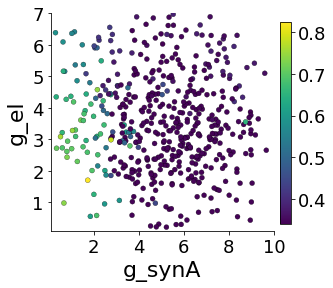

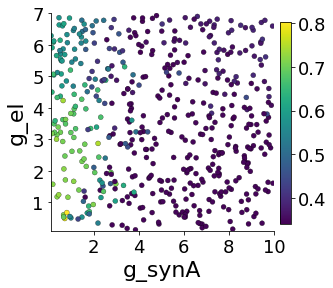

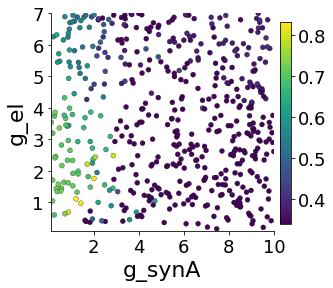

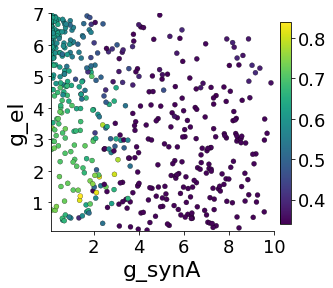

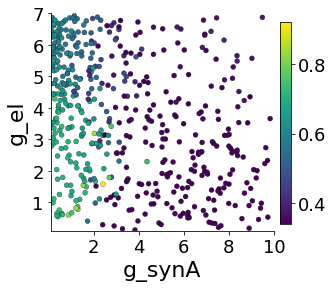

In [24]:
epi_df2 = epi_df[epi_df['path'] == paths[0]]
df_row = epi_df2.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)
    
M = 500
for k in range(5):
    dist = model._get_epi_dist(k, init_params, nf, mu, aug_lag_hps)
                 
    z, log_q_z = dist.nf(M)
    z = z.numpy()
    log_q_z = log_q_z.numpy()
    T_x = model.eps(z).numpy()
    print(np.mean(T_x, axis=0))
                 
    fig, axs, = pairplot(z, range(2), s=25, labels=[p.name for p in model.parameters],
                         fontsize=22, lb=dist.nf.lb, ub=dist.nf.ub, figsize=(4,4),
                         c=T_x[:,0], c_label='')


In [9]:
best_Hs = []
convergeds = []
best_ks = []
for path in paths:
    epi_df2 = epi_df[epi_df['path'] == path]
    df_row = epi_df2.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=0.25)
    print(best_k, best_H)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)
    
bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
0.13_0.00
None None
0.54_0.00
None None
0.00_0.00
None None
0.80_0.00
None None


In [8]:
best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)

path = paths[ind]
best_k = int(best_ks[ind])
best_H = best_Hs[ind]

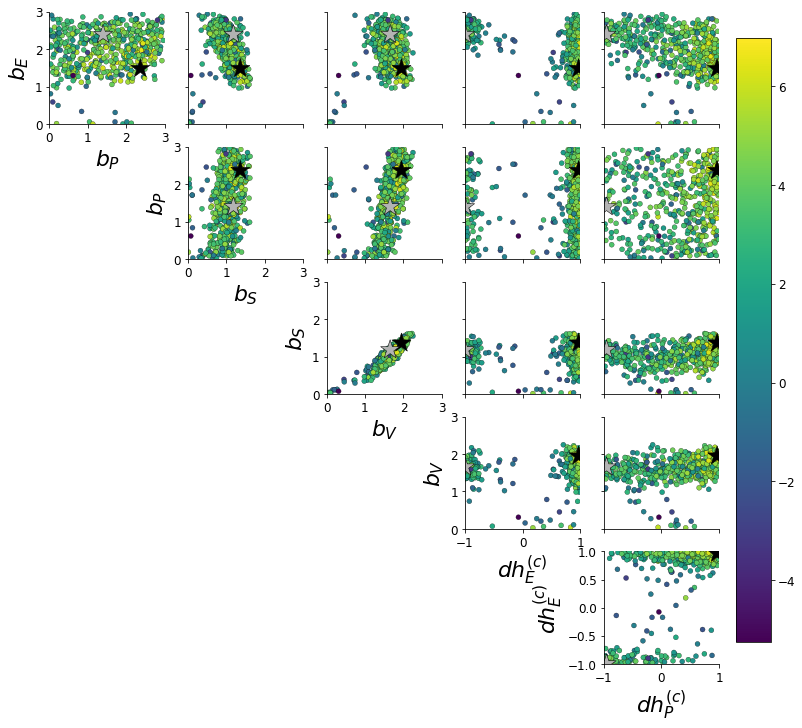

In [10]:
M = 500
s = 25

z, log_q_z = dist.nf(M)
z = z.numpy()
log_q_z = log_q_z.numpy()

z1 = z[z[:,4] > 0., :]
log_q_z1 = log_q_z[z[:,4] > 0.]
z2 = z[z[:,4] < 0., :]
log_q_z2 = log_q_z[z[:,4] < 0.]
z_mode1 = z1[np.argmax(log_q_z1)][None,:]
z_mode2 = z2[np.argmax(log_q_z2)][None,:]
z_modes = np.concatenate((z_mode1, z_mode2), axis=0)
np.savez('SV_mode.npz', z_mode1=z_mode1, z_mode2=z_mode2)

alpha_c_star = 1.
c_star = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star]))),
             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]


neurons = [alpha for alpha in neuron_inds.keys()]
labels = [r'$b_%s$' % alpha for alpha in neurons]
labels += [r'$dh^{(c)}_%s$' % alpha for alpha in neurons[:2]]
fig, axs, = pairplot(z, range(6), labels, s=s,
                     fontsize=22, lb=dist.nf.lb, ub=dist.nf.ub,
                     c=log_q_z, c_label='', starred=z_modes, c_starred=c_star)
plt.savefig(figdir + 'SV_flip_z.png')

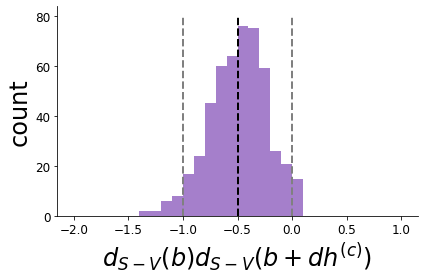

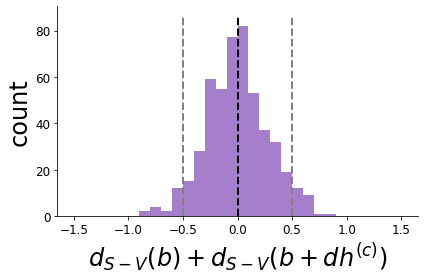

In [12]:
from epi.util import plot_T_x

T_x = model.eps(z).numpy()
xmins = [-2, -1.5]
xmaxs = [1, 1.5]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh^{(c)})$",
           r"$d_{S-V}(b) + d_{S-V}(b+dh^{(c)})$"]
for i in range(2):
    plot_T_x(None, T_x[:,i], xmin=xmins[i], xmax=xmaxs[i], 
             x_mean = mu[i], x_std = np.sqrt(mu[i+2]),
             xlabel=xlabels[i], fontsize=24)
    plt.tight_layout()
    plt.savefig(figdir + 'SVflip_Tx%d.png' % (i+1))

In [13]:
def V1_sim(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

def plot_sims(z, sigma_eps=0.05, gamma_lims=(-1,2), M=200, subscript=None, fontsize=14):
    h = z[:4][None,:]
    dh = z[4:][None,:]


    _h = np.tile(h, [M, 1])
    _dh = np.tile(dh, [M, 1])
    r_ts = []
    gammas = np.concatenate((np.array([0,1,]), np.linspace(gamma_lims[0], gamma_lims[1], 101)))
    for gamma in gammas:
        r_ts.append(V1_sim(_h, gamma*_dh))
    r_ts = np.array(r_ts)
    mean_r_ts = np.mean(r_ts, axis=1)
    std_r_ts = np.std(r_ts, axis=1)

    t = 0.005*np.arange(101)
    fig, axs = plt.subplots(1,3, figsize=(12,4))

    for i in range(4):
        axs[0].plot(t, mean_r_ts[0,i,:], c=colors[i])
        axs[0].fill_between(t, 
                            mean_r_ts[0,i,:]-std_r_ts[0,i,:],
                            mean_r_ts[0,i,:]+std_r_ts[0,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[1].plot(t, mean_r_ts[1,i,:], c=colors[i])
        axs[1].fill_between(t, 
                            mean_r_ts[1,i,:]-std_r_ts[1,i,:],
                            mean_r_ts[1,i,:]+std_r_ts[1,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[2].plot(gammas[2:], mean_r_ts[2:,i,-1], c=colors[i])
        axs[2].fill_between(gammas[2:], 
                            mean_r_ts[2:,i,-1]-std_r_ts[2:,i,-1],
                            mean_r_ts[2:,i,-1]+std_r_ts[2:,i,-1],
                            facecolor=colors[i], alpha=0.5)
        
    axs[0].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[0].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[0].set_title(r'$b_%d$' % subscript, fontsize=fontsize+4)
    else:
        axs[0].set_title(r'$b$', fontsize=fontsize+4)
    axs[0].set_ylim([0, 7])
    
    axs[1].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[1].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[1].set_title(r'$b_%d + dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[1].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
    axs[1].set_ylim([0, 7])
    
    axs[2].set_xlabel(r"$c \propto $contrast", fontsize=fontsize)
    axs[2].set_ylabel(r'$r_{ss}$', fontsize=fontsize)
    if subscript is not None:
        axs[2].set_title(r'$b_%d + c dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[2].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
    axs[2].set_ylim([0, 7])

    return gammas[2:], mean_r_ts[2:], std_r_ts[2:]


[1.4818602 2.363198  1.3598033 1.9479313 0.9672495 0.9661778]


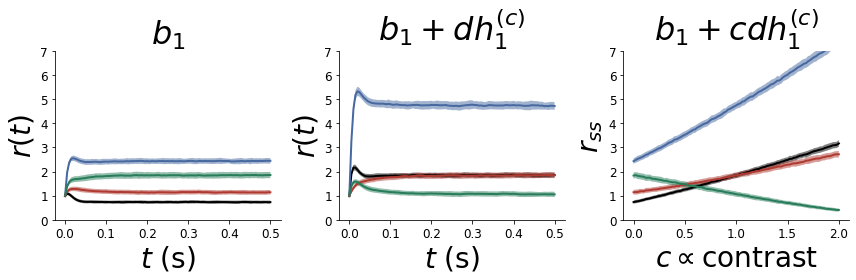

In [14]:
gamma, mean_r_ts, std_r_ts = plot_sims(z_mode1[0], sigma_eps=sigma_eps, gamma_lims=(0,2), M=200, subscript=1, fontsize=28)
plt.tight_layout()
plt.savefig(figdir + "z_mode1_sim.png")
print(z_mode1[0])

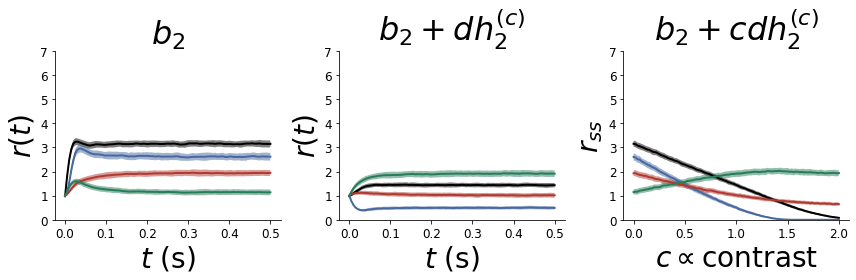

In [16]:
gamma, mean_r_ts, std_r_ts = plot_sims(z_mode2[0], sigma_eps=sigma_eps, gamma_lims=(0,2), M=200, subscript=2, fontsize=28)
plt.tight_layout()
plt.savefig(figdir + "z_mode2_sim.png")

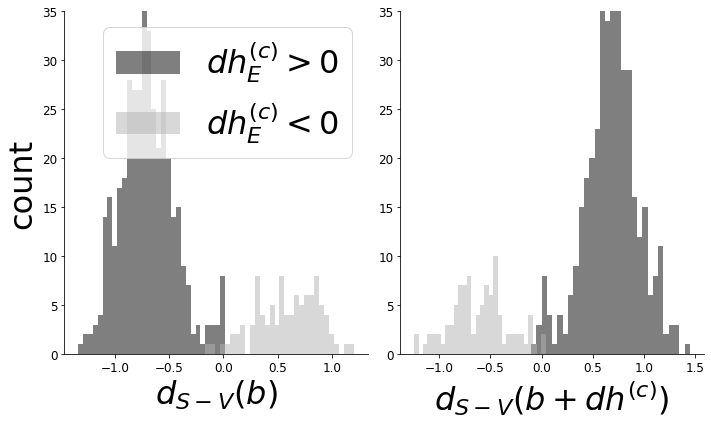

In [15]:
h = z[:,:4]
dh = z[:,4:6]
r_t1s = []
r_t2s = []
r_t1s = V1_sim(h, 0.*dh)
r_t2s = V1_sim(h, dh)
   
SV_diff1 = (r_t1s[:,2,-1] - r_t1s[:,3,-1]).numpy()
SV_diff2 = (r_t2s[:,2,-1] - r_t2s[:,3,-1]).numpy()
nbins = 30

label1 = r'$dh^{(c)}_E > 0$'
label2 = r'$dh^{(c)}_E < 0$'

fontsize = 32

fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].hist(SV_diff1[dh[:,0] > 0.], nbins, color='k', alpha=0.5, label=label1)
axs[0].hist(SV_diff1[dh[:,0] < 0.], nbins, color=.7*np.ones((3,)), alpha=0.5, label=label2)
axs[0].set_xlabel(r'$d_{S-V}(b)$', fontsize=fontsize)
axs[0].set_ylabel("count", fontsize=fontsize)
axs[0].legend(fontsize=fontsize)
axs[0].set_ylim([0,35])
axs[1].hist(SV_diff2[dh[:,0] > 0.], nbins, color='k', alpha=0.5, label=label1)
axs[1].hist(SV_diff2[dh[:,0] < 0.], nbins, color=.7*np.ones((3,)), alpha=0.5, label=label2)
axs[1].set_xlabel(r'$d_{S-V}(b + dh^{(c)})$', fontsize=fontsize)
axs[1].set_ylim([0,35])
plt.tight_layout()
plt.savefig(figdir + "SVflip_sim_diffs.png")
plt.show()

In [28]:
fac = 10
npzfile = np.load("data/V1_Zs.npz")
_W = npzfile["Z_allen_square"][None, :, :]
_W[:, :, 1:] = -_W[:, :, 1:]
W_E = fac*_W[0,0,:]

def V1_sim(h, dh):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = fac*tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

def ISN_coeff(z):
    h = z[:,:4]
    dh = z[:,4:]

    r_ts = V1_sim(h, 0.*dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff1 = 1.-2*(u_E)*W_E[0]
    
    r_ts = V1_sim(h, dh)
    r_ss = r_ts[:,:,-1].numpy()
    h_E = h[:,0] + dh[:,0]
    u_E = np.dot(W_E, r_ss.T) + h_E
    u_E[u_E < 0.] = 0.
    ISN_coeff2 = 1.-2*(u_E)*W_E[0]
    
    return ISN_coeff1, ISN_coeff2

ISN_coeff1, ISN_coeff2 = ISN_coeff(z)

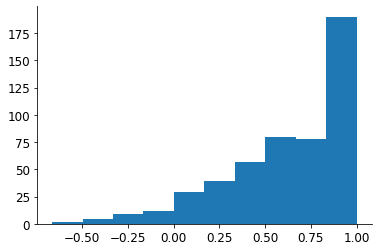

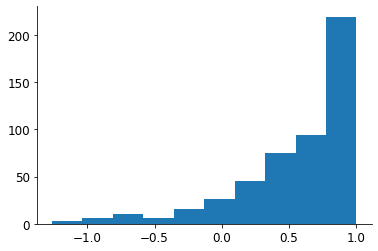

In [29]:
plt.figure()
plt.hist(ISN_coeff1)
plt.show()

plt.figure()
plt.hist(ISN_coeff2)
plt.show()
